In [1]:
import os
import zipfile
import numpy as np
from PIL import Image
from datetime import date
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from datetime import date, timedelta
import shutil

from snappy import ProductIO, GPF, HashMap, ProductUtils, PixelPos, GeoPos, ProductData, jpy
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter

%matplotlib inline

INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
Currently installed 9.0.0, available is 10.0.0.
Please visit http://step.esa.int



In [2]:
# Input
ROI_FOLDER = Path('/home/jovyan/earth-observations/notebooks/ROI')
S3_ROOT_FOLDER = Path('/home/jovyan/earth-observations/notebooks')
ROI = "IO"
YEAR = "2024"
MONTH = "February"
DAY = "22"

In [ ]:
# Output
F = S3_ROOT_FOLDER / 'S3' / 'C2RCC' / ROI

In [3]:
# Parameters

sal = 35.0
temp = 15.0
ozo = 330.0
pres = 1000.0
TSMfakBpart = 1.72
TSMfakBwit = 3.1
CHLexp = 1.04
CHLfak = 21.0
thresholdRtosaOOS = 0.005
thresholdAcReflecOos = 0.1
thresholdCloudTDown865 = 0.955
outputAsRrs = False
deriveRwFromPathAndTransmittance = False
useEcmwfAuxData = True
outputRtoa = True
outputRtosaGc = False
outputRtosaGcAann = False
outputRpath = False
outputTdown = False
outputTup = False
outputAcReflectance = True
outputRhown = True
outputOos = False
outputKd = True
outputUncertainties = True

In [4]:
footprint = geojson_to_wkt(read_geojson(ROI_FOLDER / 'indre-oslofjord.geojson'))

In [5]:
def read_S3(filename):
    reader = ProductIO.getProductReader('SENTINEL-3')
    return  ProductIO.readProduct(filename)

In [6]:
FILENAME_NO_EXT = "./S3/L1/IO/2024/March/22/S3A_OL_1_EFR____20240322T102852_20240322T103152_20240323T105256_0179_110_222_1980_PS1_O_NT_003.SEN3"
p = read_S3(FILENAME_NO_EXT)

In [7]:
# print(list(p.getBandNames()))

In [8]:
def crop_product(product):

    HashMap = jpy.get_type('java.util.HashMap')
    parameters = HashMap()
    
    parameters.put('copyMetadata', True)
    parameters.put('geoRegion', footprint)

    return GPF.createProduct('Subset', parameters, product)

image_subset = crop_product(p)


100% done.


INFO: org.hsqldb.persist.Logger: dataFileCache open start


In [9]:
def plotBand(product, band):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary)
    
    return  

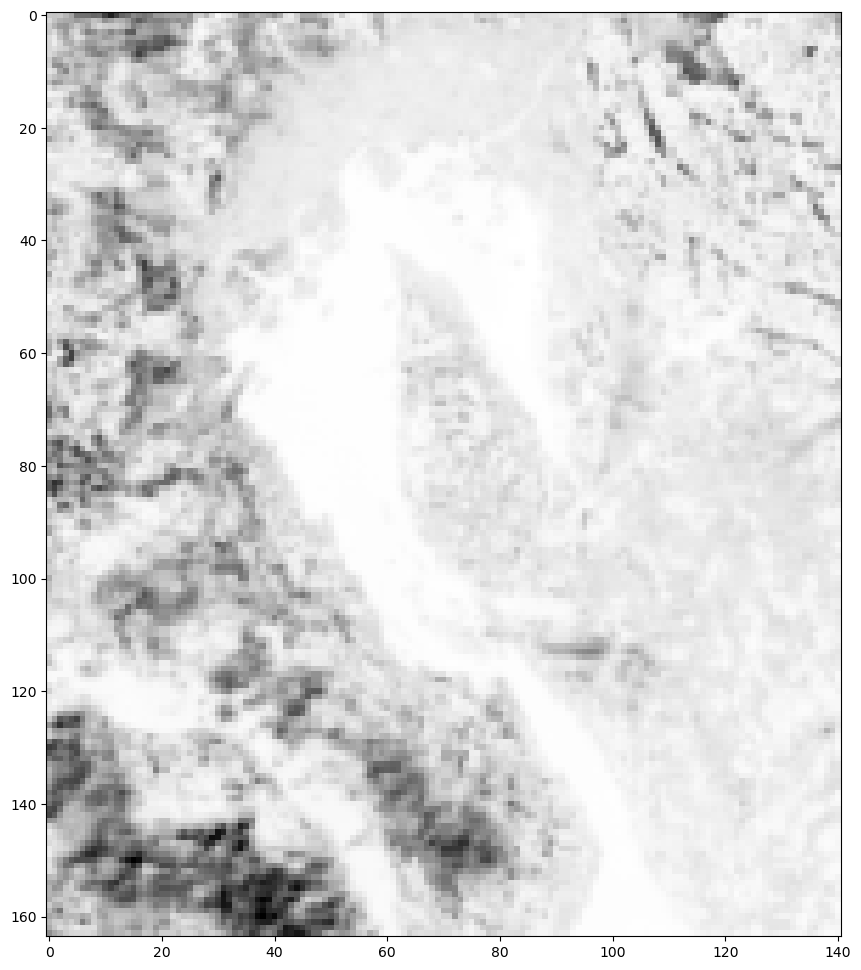

In [11]:
plotBand(image_subset, 'Oa08_radiance')

In [22]:
def reproject_product(product, crs='EPSG:4326'):
    """
    Return the product, projected with the selected 
    """

    HashMap = jpy.get_type('java.util.HashMap') 
    parameters = HashMap()
    
    parameters.put('crs', crs) 
    parameters.put('noDataValue', 0.0)

    return GPF.createProduct('Reproject', parameters, product)

In [23]:
p2 = reproject_product(p)

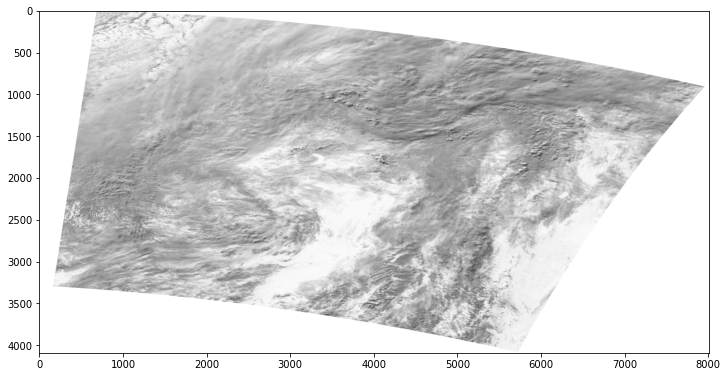

In [20]:
plotBand(p2, 'Oa08_radiance')

In [12]:
def plotRGB(product):
    red_radiance = product.getBand('Oa08_radiance')
    green_radiance = product.getBand('Oa06_radiance')
    blue_radiance = product.getBand('Oa04_radiance')
    
    w = red_radiance.getRasterWidth()
    h = red_radiance.getRasterHeight()
    
    red_radiance_data = np.zeros(w * h, np.float32)
    red_radiance.readPixels(0, 0, w, h, red_radiance_data)
    red_radiance_data.shape = h, w
    
    green_radiance_data = np.zeros(w * h, np.float32)
    green_radiance.readPixels(0, 0, w, h, green_radiance_data)
    green_radiance_data.shape = h, w
    
    blue_radiance_data = np.zeros(w * h, np.float32)
    blue_radiance.readPixels(0, 0, w, h, blue_radiance_data)
    blue_radiance_data.shape = h, w
    
    xmax=200
    red = (red_radiance_data*256/(xmax-np.amin(red_radiance_data)))
    green = (green_radiance_data*256/(xmax-np.amin(green_radiance_data)))
    blue = (blue_radiance_data*256/(xmax-np.amin(blue_radiance_data)))
    
    rgb_uint8 = np.dstack((red, green, blue)).astype(np.uint8) 
    
    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    img = Image.fromarray(rgb_uint8)
    imgplot = plt.imshow(img)

In [15]:
# plotRGB(image_subset)

In [14]:
opSpi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi("c2rcc.olci")

paramDescList = opSpi.getOperatorDescriptor().getParameterDescriptors()
for param in paramDescList:
    print(param.getName())

validPixelExpression
salinity
temperature
ozone
press
TSMfakBpart
TSMfakBwit
CHLexp
CHLfak
thresholdRtosaOOS
thresholdAcReflecOos
thresholdCloudTDown865
atmosphericAuxDataPath
alternativeNNPath
outputAsRrs
deriveRwFromPathAndTransmittance
useEcmwfAuxData
outputRtoa
outputRtosaGc
outputRtosaGcAann
outputRpath
outputTdown
outputTup
outputAcReflectance
outputRhown
outputOos
outputKd
outputUncertainties


In [16]:
def run_c2rcc(product):
    """
    Run C2RCC on the product 
    """

    HashMap = jpy.get_type('java.util.HashMap') 
    parameters = HashMap()

    parameters.put('validPixelExpression', '!quality_flags.invalid && (!quality_flags.land || quality_flags.fresh_inland_water)')
    parameters.put('temperature', 15.0)
    parameters.put('salinity', 35.0)
    parameters.put('ozone', 330.0)
    parameters.put('press', 1000.0)
    parameters.put('TSMfakBpart', 1.72)
    parameters.put('TSMfakBwit', 3.1)
    parameters.put('CHLexp', 1.04)
    parameters.put('CHLfak', 21.0)
    parameters.put('thresholdRtosaOOS', 0.005)
    parameters.put('thresholdAcReflecOos', 0.1)
    parameters.put('thresholdCloudTDown865', 0.955)
    parameters.put('outputAsRrs', True)
    parameters.put('deriveRwFromPathAndTransmittance', True)
    parameters.put('useEcmwfAuxData', True)
    parameters.put('outputRtoa', True)
    parameters.put('outputRtosaGc', True)
    parameters.put('outputRtosaGcAann', True)
    parameters.put('outputRpath', True)
    parameters.put('outputTdown', True)
    parameters.put('outputTup', True)
    parameters.put('outputAcReflectance', True)
    parameters.put('outputRhown', True)
    parameters.put('outputOos', True)
    parameters.put('outputKd', True)
    parameters.put('outputUncertainties', True)

    # opSpi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi("c2rcc.olci")
    
    return GPF.createProduct('c2rcc.olci', parameters, product)

In [17]:
result = run_c2rcc(image_subset)

Preparing computation


INFO: org.esa.s3tbx.c2rcc.olci.C2rccOlciOperator: c2rcc initial tile : null, configured tile: java.awt.Dimension[width=1217,height=1023]


50%100% done.


In [18]:
def save_result(result):
    # write_format = 'NetCDF4-CF' # BEAM-DIMAP, GeoTIFF, GeoTIFF-BigTIFF
    write_format = 'BEAM-DIMAP' # NetCDF4-CF, BEAM-DIMAP, GeoTIFF, GeoTIFF-BigTIFF

    # ProductIO.getProductWriter('GeoTIFF')
    ProductIO.writeProduct(result, './moutput.nc', write_format)
    
save_result(result)

In [20]:
def read_BEAM(filename):
    reader = ProductIO.getProductReader('BEAM-DIMAP')
    return ProductIO.readProduct(filename)

In [23]:
FLN = "./moutput.nc.dim"
ppp = read_BEAM(FLN)

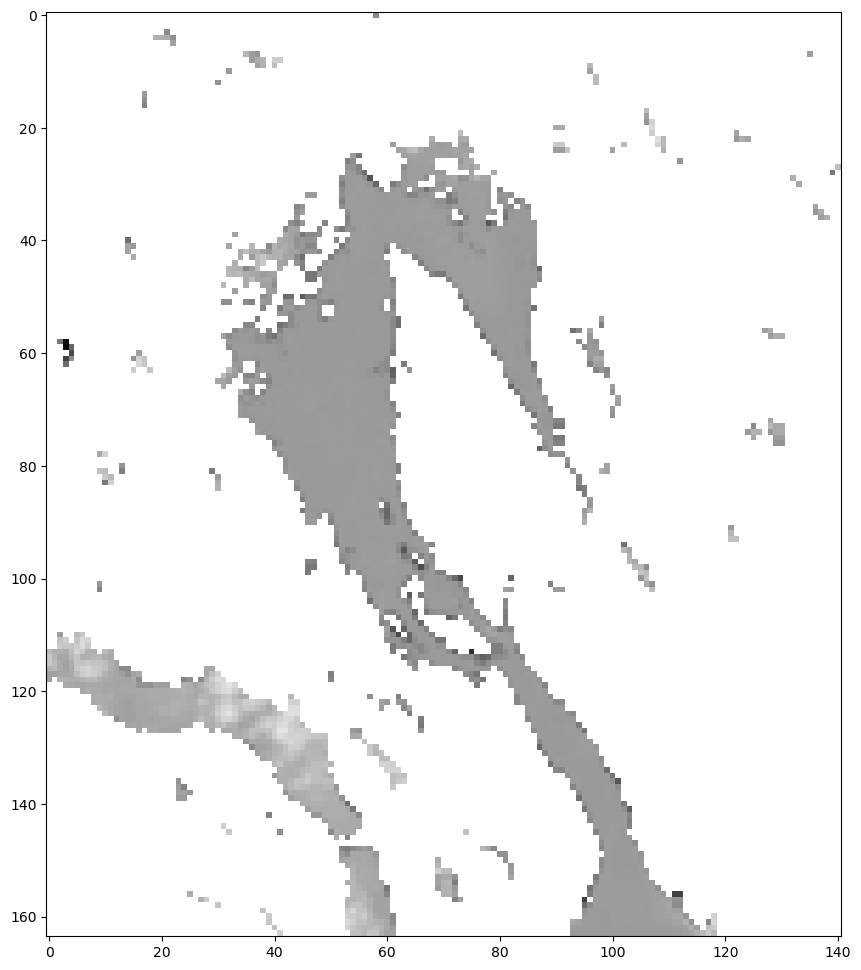

In [24]:
plotBand(ppp, 'iop_apig')